In [46]:
import gzip
import os
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random

In [47]:
# If RELEASE_MODE is True, then:
#  - plot all data
#  - save figures as pdf

RELEASE_MODE = True
if "RELEASE_MODE" in os.environ and os.environ["RELEASE_MODE"] == "1":
    RELEASE_MODE = True
    

# If RELEASE_MODE is False, use a smaller sample. This makes tweaking charts faster/easier
def simplify_data(data):
    if RELEASE_MODE:
        return data
    else:
        num_samples = len(data) / 100
        sampled = []
        for (index, v) in enumerate(data):
            probability = (num_samples - len(sampled)) / (len(data) - index)
            if random.random() < probability:
                sampled.append(v)
        return sampled
        

In [48]:
with gzip.open("../../data/background/witness-size.json.gz") as f:
    witness_sizes = simplify_data(json.load(f))
    
with gzip.open("../../data/background/block-size.json.gz") as f:
    block_sizes = simplify_data(json.load(f))
    
with gzip.open("../../data/background/db-bytes.json.gz") as f:
    db_bytes = simplify_data(json.load(f))
    
with gzip.open("../../data/background/db-ops.json.gz") as f:
    db_ops = simplify_data(json.load(f))



In [49]:
def plot_sizes(data, ax, title, ylabel, *, rolling=1):
    i = max(range(len(data)), key=lambda i: data[i][1])
    print("max size:", data[i])
    ax.margins(0.01)
    ax.scatter([x[0] for x in data], np.convolve([x[1] for x in data], np.ones((rolling,))/rolling, mode='same'), 
               s=1, rasterized=True)
    ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: str(int(x))))
    ax.tick_params(labelsize=14)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel("Block Number", fontsize=18)
    return ax

max size: [2806693, 718140]


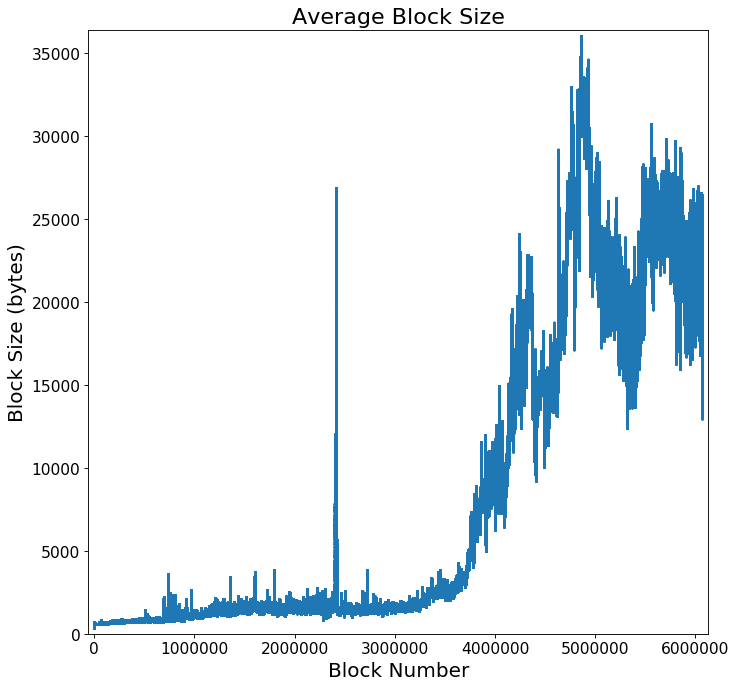

In [50]:
block_size_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = block_size_fig.add_subplot(1,1,1)
plot_sizes(block_sizes, ax, "Average Block Size", "Block Size (bytes)", rolling=2000)
ax.get_yaxis().set_major_locator(ticker.MultipleLocator(5000))

max size: (2306350, 46.926419258117676)


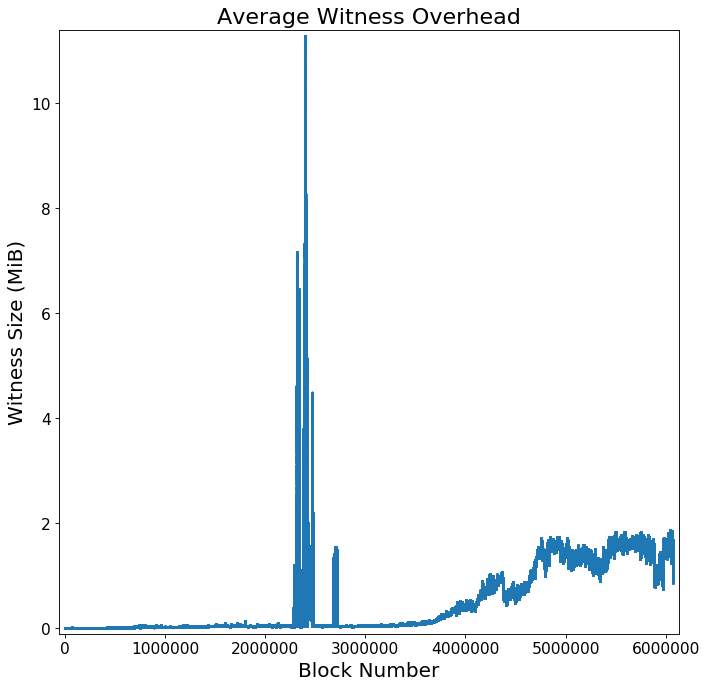

In [51]:
witness_size_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = witness_size_fig.add_subplot(1,1,1)
plot_sizes([(x[0], x[1] / (1024 * 1024)) for x in witness_sizes], ax, "Average Witness Overhead", "Witness Size (MiB)", rolling=2000)
# ax.get_yaxis().set_major_locator(ticker.MultipleLocator(2))

In [52]:
def plot_db_stats(data, ax, title, ylabel, *, rolling=1):
    ax.margins(0.01)
    read_scatter = ax.scatter([x[0] for x in data], 
                              np.convolve([x[1] for x in data], np.ones((rolling,))/rolling, mode='same'),
                              s=1, rasterized=True)
    write_scatter = ax.scatter([x[0] for x in data], 
                               np.convolve([x[2] for x in data], np.ones((rolling,))/rolling, mode='same'),
                               s=1, rasterized=True)
    delete_scatter = ax.scatter([x[0] for x in data], 
                                np.convolve([x[3] for x in data], np.ones((rolling,))/rolling, mode='same'),
                                s=1, rasterized=True)
    ax.legend((read_scatter, write_scatter, delete_scatter), ("Read", "Write", "Delete"), fontsize=12, markerscale=5)
    ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: str(int(x))))
    ax.tick_params(labelsize=12)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel("Block Number", fontsize=16)
    return ax

In [ ]:
db_io_bytes_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = db_io_bytes_fig.add_subplot(1, 1, 1)
plot_db_stats([[x[0], x[1] / (1024 * 1024), x[2] / (1024 * 1024), x[3] / (1024 * 1024)] for x in db_bytes], ax, "Database I/O", "I/O (MiB)", rolling=200)

In [ ]:
db_io_ops_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = db_io_ops_fig.add_subplot(1, 1, 1)
plot_db_stats(db_ops, ax, "Database I/O Operations", "Number of Operations", rolling=200)
ax.get_yaxis().set_major_locator(ticker.MultipleLocator(10000))

In [ ]:
if RELEASE_MODE:
    block_size_fig.savefig("block-size.pdf", transparent=False)
    witness_size_fig.savefig("witness-size.pdf", transparent=False)
    db_io_bytes_fig.savefig("db-io-bytes.pdf", transparent=False)
    db_io_ops_fig.savefig("db-io-ops.pdf", transparent=False)